In [1]:
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc
from numba import jit, njit, cuda, float64, uint32
import torch
import timeit

In [2]:
DTWDefaultSteps = np.array([[1, 1, 2],
                            [1, 2, 1]], dtype = np.uint32)

DTWDefaultWeights = np.array([2, 3, 3], dtype = np.float64)


subseqDTWDefaultSteps = np.array([[1, 1, 2],
                                  [1, 2, 1]], dtype = np.float64)

subseqDTWDefaultWeights = np.array([1, 1, 2], dtype = np.float64)


MAX_FLOAT = float('inf')

In [3]:
featureFile1 = "implementation_test/test_features/Features_1.npy"
featureFile2 = "implementation_test/test_features/Features_2.npy"
featureFile3 = "implementation_test/test_features/Features_3.npy"
featureFile4 = "implementation_test/test_features/Features_4.npy"

In [4]:
@njit
def DTW_Cost_To_DandB(C, Steps = DTWDefaultSteps, weights = DTWDefaultWeights, subsequence=False):
    '''
    Find the accumulated cost matrix and backtrace matrix from a cost matrix using Dynamic time warping
    
    Arguments:
    C -- The Cost matrix
    Steps -- The available steps, where the first row is the row steps, the second row is the column steps
    weights -- The weights of the steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
             
    Returns:
    D -- The accumulated cost matrix
    B -- The backtrace matrix
    '''
    '''
    Section for verifying input
    '''
    # Ensure parameters have correct dtypes and dimensions
    try:
        C = C.astype(np.float64)
        assert C.ndim == 2
    except:
        print("FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        Steps = Steps.astype(np.uint32)
        assert Steps.ndim == 2
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        weights = weights.astype(np.float64)
        assert weights.ndim == 1
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return
    
    # Ensure steps and weights sizes are appropriate
    stepsShape = Steps.shape
    numDifSteps = len(weights)
    
    if stepsShape[0] != 2:
        print("FAILURE: The size of the steps matrix is wrong - please pass in a 2-d numpy array with 2 rows")
        return
    if stepsShape[1] != numDifSteps:
        print("FAILURE: The number of steps and weights do not line up - please make sure that there are the same number of steps and weights")
        return
    
    '''
    Algorithm
    '''
    # Separate steps
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]

    # Define Relevant Variables
    numRows = C.shape[0]
    numCols = C.shape[1]
    
    numDifSteps = len(weights)
    maxRowStep = max(rowSteps)
    maxColStep = max(colSteps)
    
    # Set up accumulated cost matrix D and backtrace matrix B
    D = np.ones((numRows + maxRowStep, numCols + maxColStep), dtype = np.float64) * MAX_FLOAT
    B = np.zeros((numRows, numCols), dtype = np.uint32)
    
    # Fill up D and B
    if subsequence:  # Initialize entire bottom row of D for subsequence
        D[maxRowStep, maxColStep:] = C[0,:]
    else:
        D[maxRowStep, maxColStep] = C[0,0]  # Initialize bottom corner if for standard DTW
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = D[row, col]
            bestCostIndex = 0
            # Go through each step, find the best one
            for stepIndex in range(numDifSteps):
                costForStep = D[row - rowSteps[stepIndex], col - colSteps[stepIndex]] + weights[stepIndex] * C[row - maxRowStep, col - maxColStep]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # Save best cost and step
            D[row,col] = bestCost
            B[row - maxRowStep, col - maxColStep] = bestCostIndex
    
    # Return accumulated cost matrix D and backtrace matrix B
    return D[maxRowStep:, maxColStep:], B

In [5]:
@njit
def DTW_Backtrace(D, B, Steps=DTWDefaultSteps, subsequence=False, startCol=-1):
    '''
    Backtrace through an accumulated cost matrix and backtrace matrix to find a path
    
    Arguments:
    D -- The accumulated cost matrix
    B -- The backtrace matrix
    Steps -- The available steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
    startCol -- The column to begin backtracing from, or -1 if not specified
    
    Returns:
    fwdPath -- A 2d numpy array storing the optimal path. The first row is the path through the rows.
            The second row is the path through the columns
    '''
    '''
    Section for verifying input
    '''
    # Ensure parameters have correct dtypes and dimensions
    try:
        D = D.astype(np.float64)
        assert D.ndim == 2
    except:
        print("FAILURE: The type of the accumulated cost matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        B = B.astype(np.uint32)
        assert B.ndim == 2
    except:
        print("FAILURE: The type of the backtrace matrix is wrong - please pass in a 2-d numpy array")
        return
    
    try:
        Steps = Steps.astype(np.uint32)
        assert Steps.ndim == 2
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return

    # Ensure that D and B are the same shape
    if D.shape != B.shape:
        print("FAILURE: The accumulated cost matrix and backtrace matrix are not the same size - please make sure their sizes match")
        return
    
    
    '''
    Backtrace through D and B
    '''
    # Separate steps
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]
    
    # Initialize variables
    numRows = D.shape[0]
    numCols = D.shape[1]
    
    curRow = numRows - 1  # Always start at last row
    curCol = numCols - 1  # Standard DTW: Start at top-right corner
    if startCol > 0:
        curCol = startCol
    elif subsequence:  # Subsequence: Choose lowest cost of top row
        curCol = np.argmin(D[numRows-1,:])
    
    endCol = curCol
    endCost = D[curRow, curCol]
    stepsInPath = 1
    stepIndex = 0
    done = (subsequence and curRow == 0) or (curRow == 0 and curCol == 0)
    path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol
    # Backtrace
    while not done:
        if D[curRow, curCol] == MAX_FLOAT:  # No path exists to current location
            return
        
        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = B[curRow, curCol]
        curRowStep = rowSteps[curStepIndex]
        curColStep = colSteps[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subsequence and curRow == 0) or (curRow == 0 and curCol == 0)
    # reverse the path (a matrix with two rows) and return it
    fwdPath = np.fliplr(path[:, 0:stepsInPath])
    return fwdPath
    #return fwdPath, endCol, endCost

In [6]:
@njit
def getSegmentEndingLocs(wp):
    '''
    Takes in a segment level path through and returns the columns where each segment ends
    
    Arguments:
    wp -- A segment level path (as a 2d numpy array with 2 rows)
    
    Returns:
    endLocs -- A list where the ith entry is the column where the ith segment ends
    '''
    prevLoc = wp[:,0] # [r,c]
    endLocs = []
    for i in range(wp.shape[1]):
        curLoc = wp[:,i]
        if curLoc[0] != prevLoc[0]: # if row changes
            endLocs.append(curLoc[1])
        prevLoc = curLoc
        
    return endLocs

In [7]:
@cuda.jit
def GPU_DTW_shared(D, B, C, segLength, steps, weights):
    '''
    '''
    # Extract segments into shared memory
    i = cuda.grid(1)
    
    # init shared matrices
    #C_frag = cuda.shared.array((segLength,C.shape[1]), float64)
    #D_frag = cuda.shared.array((segLength,C.shape[1]), float64)
    C_shared = cuda.shared.array(shape=0, dtype=float64)
    
    segWidth = C.shape[1]
    
    #C_shared = np.zeros(segWidth*segLength*2 + 9, dtype = np.float64)
    
    
    COffset = 9
    DOffset = segWidth*segLength + COffset
    # fill matrices
    for r in range(segLength):
        for c in range(segWidth):
            C_shared[COffset+r*segWidth+c] = C[int(min(i*segLength+r, C.shape[0])), c]
            C_shared[DOffset+r*segWidth+c] = D[int(min(i*segLength+r, C.shape[0])), c]
    
    for j in range(steps.shape[0]):
        for k in range(steps.shape[1]):
            C_shared[3*j + k] = steps[j,k]
            
    for j in range(len(weights)):
        C_shared[6 + j] = weights[j]

    
    # Run DTW
    
    numSteps = 3
    
    # Fill up D and B
    for c in range(segWidth): # subsequence init
        C_shared[DOffset+c] = C_shared[COffset+c] 
    
    for row in range(segLength):
        for col in range(segWidth):
            bestCost = C_shared[DOffset+row*segWidth+col]
            bestCostIndex = 0
            # Go through each step, find the best one
            for stepIndex in range(numSteps):
                if row - C_shared[stepIndex] < 0 or col - C_shared[numSteps+stepIndex] < 0:
                    continue
                
                costForStep = C_shared[int(DOffset + (row - C_shared[stepIndex]) * segWidth + col \
                            - C_shared[numSteps + stepIndex])] + C_shared[int(2 * numSteps + stepIndex)] * \
                            C_shared[int(COffset + row*segWidth + col)]
                
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # Save best cost and step
            C_shared[DOffset + row * segWidth + col] = bestCost
            B[row + i*segLength, col] = bestCostIndex
    
    # Copy D and B segments into global memory
    for r in range(segLength):
        if (i*segLength + r == C.shape[0]):
            break
        for c in range(segWidth):
            D[i*segLength+r, c] = C_shared[DOffset + r * segWidth + c]

In [8]:
@cuda.jit
def GPU_DTW_global(D, B, C, segLength, steps, weights):
    '''
    '''
    # Extract segments into shared memory
    i = cuda.grid(1)
    #i=0
    
    offset = i*segLength
    segWidth = C.shape[1]
    
    # Run DTW
    
    numSteps = 3
    
    # Fill up D and B
    for c in range(segWidth): # subsequence init
        D[offset,c] = C[offset,c]
    
    for row in range(segLength):
        if (offset + row == C.shape[0]):
            break
        for col in range(segWidth):
            bestCost = D[offset+row,col]
            bestCostIndex = 0
            # Go through each step, find the best one
            for stepIndex in range(numSteps):
                rowStep = steps[0, stepIndex]
                colStep = steps[1, stepIndex]
                if row - rowStep < 0 or col - colStep < 0:
                    continue
                
                costForStep = D[int(offset + (row - rowStep)), int(col - colStep)] + \
                              weights[stepIndex] * C[offset + row, col]
                
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # Save best cost and step
            D[offset + row, col] = bestCost
            B[offset + row, col] = bestCostIndex

In [79]:
@jit(forceobj=True)
def GPU_WSDTW(queryFeatureFile, refFeatureFile, K, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights, \
              outfile = None, profile = False):
    '''
    '''
    
    # Extract Feature matrices
    F1 = np.load(queryFeatureFile, allow_pickle = True)
    F2 = np.load(refFeatureFile, allow_pickle = True)
    
#     F1 = F1[:, :100]
#     F2 = F2[:, :100]
    
    
    
    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
        print("FAILURE - Feature sizes are too different to align with DTW")
        return
    
    # start time logging
    times = []
    times.append(time.time())
    
    # Compute Cost
    # NOTE: This could also be done segment by segment.
    # I am doing it all up front to match the implementation in the old code.
    C = 1 - F1.T @ F2
    
    # Subsequence DTW each segment without backtracing
    segLength = int(np.ceil(F1.shape[1] / K))
    segWidth = C.shape[1]
    
    Cseg = np.zeros((K + 1, C.shape[1]), dtype = np.float64)
    D = np.ones(C.shape, dtype = np.float64) * MAX_FLOAT
    B = np.zeros(C.shape, dtype = np.int32)
    
    totalSize = C.nbytes + D.nbytes + B.nbytes
    totalSegmentSize = int(np.ceil((totalSize-B.nbytes) / K))  # If necessary, maybe just put C and D in shared memory
    times.append(time.time())
    if totalSize > torch.cuda.get_device_properties(0).total_memory:  # C > 11GB
        # Pass in fragment by fragment
        print('Fragment too large for global memory') 
        # Pass in as many fragments as possible at once
        # Some Function
        # Implement Later if Desired
    elif totalSegmentSize > 96000:  # Can't use shared memory
        print('Fragment too large for shared memory')
        GPU_DTW_global[K,1](D, B, C, segLength, Steps, weights)
        #GPU_DTW_global(D, B, C, segLength, Steps, weights)
    else:
        GPU_DTW_shared[K,1,0,totalSegmentSize+Steps.nbytes+weights.nbytes](D, B, C, segLength, Steps, weights)
        #GPU_DTW_shared(D, B, C, segLength, Steps, weights)
    times.append(time.time())
    for i in range(K):
        Cseg[i+1,:] = D[min((i+1)*segLength-1,D.shape[0]-1),:]
    
    # run segment-level DTW (Not subsequence)
    segmentSteps = np.array([[0, 1],
                             [1, C.shape[0]//(2 * K)]], #NOTE: This could cause differences with old implementation
                            dtype=np.uint32)
    segmentWeights = np.array([0, 1])
    
    Dseg, Bseg = DTW_Cost_To_DandB(Cseg, Steps = segmentSteps, weights = segmentWeights)
    times.append(time.time())
    wpseg = DTW_Backtrace(Dseg, Bseg, Steps=segmentSteps)
    times.append(time.time())
    # Backtrace through segments with segment level path as guide
    # On GPU?
    path = []
    # Frame level backtrace segment by segment
    segmentEndIdxs = getSegmentEndingLocs(wpseg)
    times.append(time.time())
    for i, endidx in enumerate(segmentEndIdxs):
        D_i = D[i*segLength:min((i+1)*segLength, D.shape[0]),:]
        B_i = B[i*segLength:min((i+1)*segLength, B.shape[0]),:]
        pathSeg = DTW_Backtrace(D_i, B_i, Steps = Steps, subsequence = True, startCol = endidx)
        # Add offset to row indices so they match with overall path
        pathSeg[0,:] = pathSeg[0,:] + (i * segLength)

        # Append fragment to full path
        path.append(pathSeg.copy())
    times.append(time.time())
    wp_merged = np.hstack(path)
    
    if outfile:
        pickle.dump(wp_merged, open(outfile, 'wb'))

    if profile:
        return wp_merged, np.diff(times)
    else:
        return wp_merged

In [80]:
@jit(forceobj = True)
def WSDTW(queryFeatureFile, refFeatureFile, segments, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights, \
          outfile = None, profile = False):
    '''
    Runs a weakly-ordered segmental DTW between query and reference features matrices
    
    Arguments:
    queryFeatureFile -- The file containing the query feature matrix
    refFeatureFile -- The file containing the reference feature matrix
    segments -- The number of segments to divide F1 into
    Steps -- The allowed steps
    weights -- The weights for the steps
    
    Returns:
    path -- The optimal weakly-ordered, segmented alignment path between F1 and F2
    '''
    # Extract Feature matrices
    F1 = np.load(queryFeatureFile, allow_pickle = True)#[:,:100]
    F2 = np.load(refFeatureFile, allow_pickle = True)#[:,:100]

    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
        print("FAILURE - Feature sizes are too different to align with DTW")
        return
    
    # start time logging
    times = []
    times.append(time.time())
    
    # Compute Cost
    # NOTE: This could also be done segment by segment.
    # I am doing it all up front to match the implementation in the old code.
    C = 1 - F1.T @ F2
    
    times.append(time.time())
    
    # Subsequence DTW each segment without backtracing
    segLength = int(np.ceil(F1.shape[1] / segments))
    Cseg = np.zeros((segments + 1, C.shape[1]), dtype = np.float64)
    Dparts = []
    Bparts = []
    for i in range(segments):
        segStart = i * segLength
        segEnd = min(segStart + segLength, C.shape[0])
        # Ensuring that the segment is contiguous here ensures best performance in later computations
        currentSeg = np.ascontiguousarray(C[segStart:segEnd,:])
        D_i, B_i = DTW_Cost_To_DandB(currentSeg, Steps = Steps, weights = weights, subsequence = True)
        
        # Store D_i and B_i for segment and construct Cseg
        Dparts.append(D_i)
        Bparts.append(B_i)
        
        # NOTE: May need to separate this into a different loop for runtime profiling
        Cseg[i + 1,:] = D_i[-1,:]
    times.append(time.time())
    
    # run segment-level DTW (Not subsequence)
    segmentSteps = np.array([[0, 1],
                             [1, C.shape[0]//(2 * segments)]], #NOTE: This could cause differences with old implementation
                            dtype=np.uint32)
    segmentWeights = np.array([0, 1])
    
    Dseg, Bseg = DTW_Cost_To_DandB(Cseg, Steps = segmentSteps, weights = segmentWeights)

    times.append(time.time())
    
    wpseg = DTW_Backtrace(Dseg, Bseg, Steps=segmentSteps)
    
    times.append(time.time())
    
    # Backtrace through segments with segment level path as guide
    path = []
    # Frame level backtrace segment by segment
    segmentEndIdxs = getSegmentEndingLocs(wpseg)
    
    times.append(time.time())
    
    for i, endidx in enumerate(segmentEndIdxs):
        pathSeg = DTW_Backtrace(Dparts[i], Bparts[i], Steps = Steps, subsequence = True, startCol = endidx)
        # Add offset to row indices so they match with overall path
        pathSeg[0,:] = pathSeg[0,:] + (i * segLength)

        # Append fragment to full path
        path.append(pathSeg.copy())
    
    wp_merged = np.hstack(path)
    
    times.append(time.time())
    
    if outfile:
        pickle.dump(wp_merged, open(outfile, 'wb'))

    if profile:
        return wp_merged, np.diff(times)
    else:
        return wp_merged

### Test with K=5

In [103]:
path, times = GPU_WSDTW(featureFile3, featureFile4, 5, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights, profile = True)

Fragment too large for shared memory


In [104]:
GTPath, GTtimes = WSDTW(featureFile3, featureFile4, 5, profile = True)

In [105]:
np.allclose(path,GTPath)

True

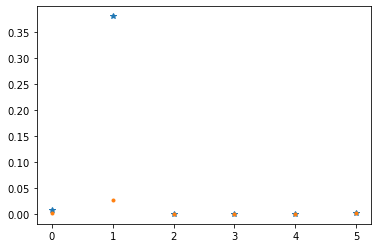

In [108]:
plt.plot(times,'*');
plt.plot(GTtimes,'.');

In [109]:
C = np.random.random((100,100))
segLength = int(np.ceil(C.shape[1] / 5))
D = np.ones(C.shape, dtype = np.float64) * MAX_FLOAT
B = np.zeros(C.shape, dtype = np.int32)

totalSize = C.nbytes + D.nbytes + B.nbytes
totalSegmentSize = int(np.ceil((totalSize-B.nbytes) / 5))
Steps = subseqDTWDefaultSteps
weights = subseqDTWDefaultWeights

In [110]:
%timeit GPU_DTW_shared[5,1,0,totalSegmentSize+Steps.nbytes+weights.nbytes](D, B, C, segLength, Steps, weights)

4.01 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
%timeit DTW_Cost_To_DandB(C, Steps = Steps, weights = weights, subsequence=True)

207 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [112]:
np.sum(times)

0.39084577560424805

In [113]:
np.sum(GTtimes)

0.0324101448059082

### Test with K=10

In [114]:
path, times = GPU_WSDTW(featureFile3, featureFile4, 10, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights, profile = True)

Fragment too large for shared memory


In [115]:
GTPath, GTtimes = WSDTW(featureFile3, featureFile4, 10, profile = True)

In [116]:
np.allclose(path,GTPath)

True

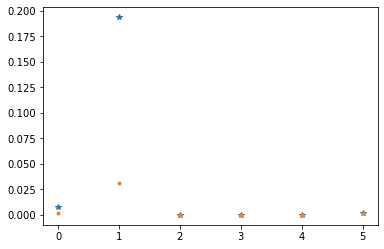

In [119]:
plt.plot(times,'*');
plt.plot(GTtimes,'.');

In [120]:
C = np.random.random((100,100))
segLength = int(np.ceil(C.shape[1] / 5))
D = np.ones(C.shape, dtype = np.float64) * MAX_FLOAT
B = np.zeros(C.shape, dtype = np.int32)

totalSize = C.nbytes + D.nbytes + B.nbytes
totalSegmentSize = int(np.ceil((totalSize-B.nbytes) / 5))
Steps = subseqDTWDefaultSteps
weights = subseqDTWDefaultWeights

In [121]:
%timeit GPU_DTW_shared[5,1,0,totalSegmentSize+Steps.nbytes+weights.nbytes](D, B, C, segLength, Steps, weights)

4 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
%timeit DTW_Cost_To_DandB(C, Steps = Steps, weights = weights, subsequence=True)

207 µs ± 696 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [123]:
np.sum(times)

0.20346498489379883

In [124]:
np.sum(GTtimes)

0.03592061996459961

### Test on Larger Matrices

In [136]:
path, times = GPU_WSDTW(featureFile1, featureFile2, 10, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights, profile = True)

Fragment too large for shared memory


In [137]:
GTPath, GTtimes = WSDTW(featureFile1, featureFile2, 10, profile = True)

In [138]:
np.allclose(path,GTPath)

True

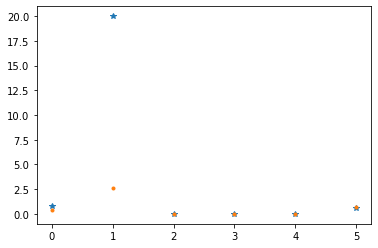

In [141]:
plt.plot(times,'*');
plt.plot(GTtimes,'.');

In [142]:
C = np.random.random((100,100))
segLength = int(np.ceil(C.shape[1] / 5))
D = np.ones(C.shape, dtype = np.float64) * MAX_FLOAT
B = np.zeros(C.shape, dtype = np.int32)

totalSize = C.nbytes + D.nbytes + B.nbytes
totalSegmentSize = int(np.ceil((totalSize-B.nbytes) / 5))
Steps = subseqDTWDefaultSteps
weights = subseqDTWDefaultWeights

In [143]:
%timeit GPU_DTW_shared[5,1,0,totalSegmentSize+Steps.nbytes+weights.nbytes](D, B, C, segLength, Steps, weights)

4.03 ms ± 9.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [144]:
%timeit DTW_Cost_To_DandB(C, Steps = Steps, weights = weights, subsequence=True)

206 µs ± 677 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [145]:
np.sum(times)

21.44457983970642

In [146]:
np.sum(GTtimes)

3.693242073059082